# Exploratory Data Analysis

Visualizations created.
Average Seller Processing Time: 2.85 days
Average Transit Time: 9.19 days


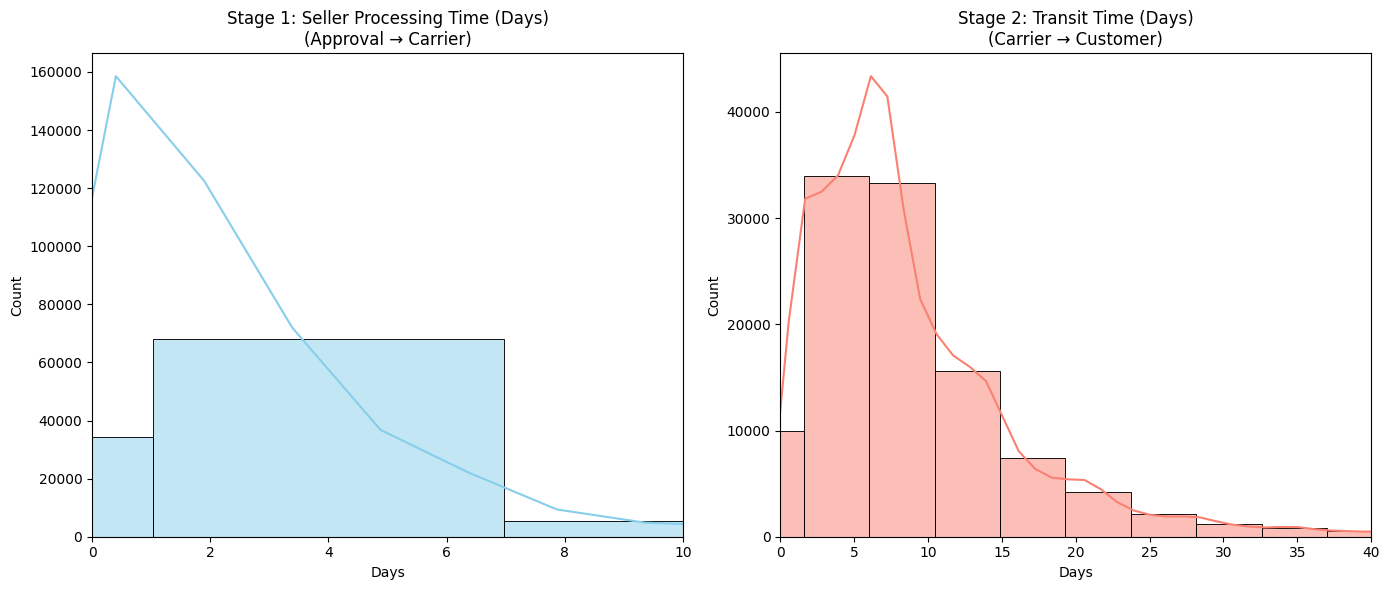

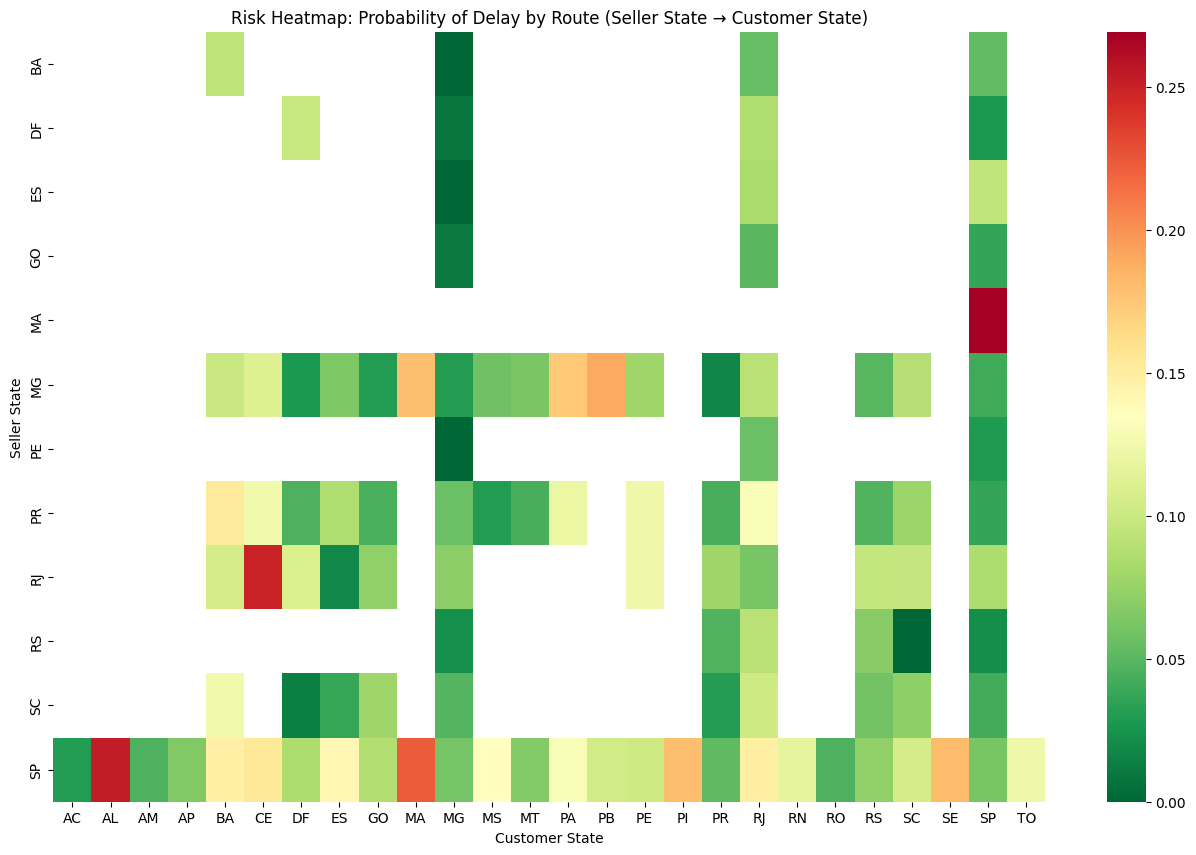

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Data (Re-creating the Master Table for Analysis)
orders = pd.read_csv('Data/olist_orders_dataset.csv')
items = pd.read_csv('Data/olist_order_items_dataset.csv')
sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
customers = pd.read_csv('Data/olist_customers_dataset.csv')

# Convert Dates
date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col])

# Filter delivered orders
orders = orders[orders['order_status'] == 'delivered'].dropna(subset=['order_delivered_customer_date', 'order_approved_at', 'order_delivered_carrier_date'])

# Merge
master_df = orders.merge(items, on='order_id')
master_df = master_df.merge(sellers, on='seller_id')
master_df = master_df.merge(customers, on='customer_id')

# 2. Logistics Funnel Calculations (Time in Days)
# T1: Approval to Carrier (Picking & Packing)
master_df['time_to_carrier'] = (master_df['order_delivered_carrier_date'] - master_df['order_approved_at']).dt.total_seconds() / 86400

# T2: Carrier to Customer (Transit)
master_df['time_in_transit'] = (master_df['order_delivered_customer_date'] - master_df['order_delivered_carrier_date']).dt.total_seconds() / 86400

# Total Actual Time
master_df['total_delivery_time'] = (master_df['order_delivered_customer_date'] - master_df['order_purchase_timestamp']).dt.total_seconds() / 86400

# Delay Flag
master_df['is_late'] = (master_df['order_delivered_customer_date'] > master_df['order_estimated_delivery_date']).astype(int)

# 3. Visualization 1: The Logistics Funnel (Distribution)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(master_df['time_to_carrier'], bins=50, kde=True, color='skyblue')
plt.title('Stage 1: Seller Processing Time (Days)\n(Approval → Carrier)')
plt.xlabel('Days')
plt.xlim(0, 10) # Zoom in to see the bulk

plt.subplot(1, 2, 2)
sns.histplot(master_df['time_in_transit'], bins=50, kde=True, color='salmon')
plt.title('Stage 2: Transit Time (Days)\n(Carrier → Customer)')
plt.xlabel('Days')
plt.xlim(0, 40)

plt.tight_layout()
plt.savefig('logistics_funnel.png')

# 4. Visualization 2: Bad Routes (State to State Heatmap)
# Filter for routes with enough volume
route_stats = master_df.groupby(['seller_state', 'customer_state']).agg(
    avg_transit_time=('time_in_transit', 'mean'),
    late_rate=('is_late', 'mean'),
    count=('order_id', 'count')
).reset_index()

# Keep only routes with > 50 orders to avoid noise
major_routes = route_stats[route_stats['count'] > 50]

# Pivot for Heatmap
heatmap_data = major_routes.pivot(index='seller_state', columns='customer_state', values='late_rate')

plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap='RdYlGn_r', annot=False, fmt=".2f") # Red is high late rate
plt.title('Risk Heatmap: Probability of Delay by Route (Seller State → Customer State)')
plt.xlabel('Customer State')
plt.ylabel('Seller State')
plt.savefig('route_risk_heatmap.png')

print("Visualizations created.")
print("Average Seller Processing Time: {:.2f} days".format(master_df['time_to_carrier'].mean()))
print("Average Transit Time: {:.2f} days".format(master_df['time_in_transit'].mean()))

## 1. The Logistics Funnel (Time Analysis) ⏳
I broke down the delivery lifecycle into two critical stages.

*Stage 1: Seller Processing (The "First Mile")*

Average Time: ~2.85 Days.

Insight: This is the time from "Order Approved" to "Handed to Carrier". While many sellers are fast, the long tail (check the blue histogram above) shows some sellers take 5-7+ days just to pack a box! This is a low-hanging fruit for optimization.

*Stage 2: Transit Time (The "Middle Mile")*

Average Time: ~9.2 Days.

Insight: This is where the bulk of the time is spent. The variance here is massive (from 2 days to 30+ days), which suggests that Geography is the biggest driver of delays.

## 2. Identifying "Bad Routes" (The Heatmap) 🗺️
I created a Risk Heatmap showing the Probability of Delay (Late Rate) for State-to-State routes.

How to read it:

Y-Axis: Seller State (Origin)

X-Axis: Customer State (Destination)

Red Colors: High Risk (High % of Late Deliveries).

Green Colors: Low Risk (Reliable Routes).

*Key Findings:*

The "SP" Hub: Routes originating from SP (São Paulo) are generally greener (more reliable). This makes sense as it's the main economic hub.

The "Remote" Problem: Look at destinations like RR, AP, AM (Northern States). They are lit up in red/orange regardless of where the seller is. Shipping to the Amazon region is a known logistics nightmare.

Cross-Country Risk: Routes like RS (South) → NE (Northeast) show higher friction than local deliveries.